**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder . Chapter 17 of Geron's book.

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
# import cv2

### **Loading the MNIST data and forming arrays of the normal training data, validation data (normal and abnormal, and the test data (normal and abnormal)**

In [ ]:
abn = 8

(x_train_0, y_train_0), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_0 = x_train_0.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

train_size = x_train_0.shape[0] * 9 // 10

x_train, x_valid, y_train, y_valid = train_test_split(x_train_0, y_train_0, train_size = train_size)

normal_data = x_train[y_train != abn]    # Normal training data (Normal digits)
normal_labels = y_train[y_train != abn]  

valid_data = x_valid                     # Validation data (both normal digits and the abnormal digit)
valid_labels = y_valid

test_data = x_test                       # Test data (both normal digits and the abnormal digit)
test_labels = y_test

test_labels_T_F = np.where(test_labels != abn, True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

valid_labels_T_F = np.where(valid_labels != abn, True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
normal_data.shape, normal_labels.shape, valid_data.shape, valid_labels.shape, test_data.shape, test_labels.shape

((48715, 28, 28), (48715,), (6000, 28, 28), (6000,), (10000, 28, 28), (10000,))

In [ ]:
normal_test_data = test_data[test_labels != abn]                   # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]                 # The abnormal digits in the test data
normal_test_labels = test_labels[test_labels != abn]               # Their labels
abnormal_test_labels = test_labels[test_labels == abn]             # Their labels

In [ ]:
normal_test_data.shape, abnormal_test_data.shape

((9026, 28, 28), (974, 28, 28))

In [ ]:
normal_valid_data = valid_data[valid_labels != abn]                  # The normal digits in the valid data
abnormal_valid_data = valid_data[valid_labels == abn]                 # The abnormal digits in the valid data
normal_valid_labels = valid_labels[valid_labels != abn]               # Their labels
abnormal_valid_labels = valid_labels[valid_labels == abn]             # Their labels

In [ ]:
normal_valid_data.shape, abnormal_valid_data.shape

((5434, 28, 28), (566, 28, 28))

### **Building and training the network** 

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256, activation="selu"),
      layers.Dense(128, activation="selu"),
      layers.Dense(64, activation="selu"),
      layers.Dense(16, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="selu"),                                  
      layers.Dense(128, activation="selu"),
      layers.Dense(256, activation="selu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=16,
          validation_data=(normal_valid_data, normal_valid_data),
          shuffle=True)

Epoch 1/100
3045/3045 [==============================] - 20s 4ms/step - loss: 0.1337 - val_loss: 0.1134
Epoch 2/100
3045/3045 [==============================] - 11s 4ms/step - loss: 0.1084 - val_loss: 0.1071
Epoch 3/100
3045/3045 [==============================] - 11s 4ms/step - loss: 0.1033 - val_loss: 0.1058
Epoch 4/100
3045/3045 [==============================] - 11s 4ms/step - loss: 0.1006 - val_loss: 0.1016
Epoch 5/100
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0988 - val_loss: 0.1014
Epoch 6/100
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0975 - val_loss: 0.0979
Epoch 7/100
3045/3045 [==============================] - 12s 4ms/step - loss: 0.0965 - val_loss: 0.0972
Epoch 8/100
3045/3045 [==============================] - 11s 4ms/step - loss: 0.0957 - val_loss: 0.0969
Epoch 9/100
3045/3045 [==============================] - 12s 4ms/step - loss: 0.0950 - val_loss: 0.0972
Epoch 10/100
3045/3045 [==============================] - 11s 4m

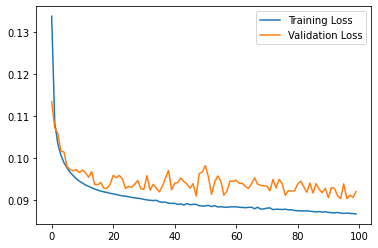

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
model = autoencoder
# model.summary(expand_nested=True, show_trainable=True)

In [ ]:
model_encoder = autoencoder.encoder
# model_encoder.summary(expand_nested=True, show_trainable=True)

In [ ]:
model_decoder = autoencoder.decoder
# model_decoder.summary(expand_nested=True, show_trainable=True)

In [ ]:
model_layers = np.array(model.layers)
n_layers = model_layers.shape[0] 
# np.concatenate((np.arange(n_layers).reshape(n_layers,1), model_layers.reshape(n_layers,1)), axis = 1)

### **The original and reconstructed images for the first 30 instances of the normal training data, validation data, normal validation data, abnormal validation data, test data, normal test data, and abnormal test data**

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [ ]:
def show_reconstructions(autoencoder, images, n_images=5):
    encoded_data = autoencoder.encoder(images[:n_images]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    reconstructions = decoded_data
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

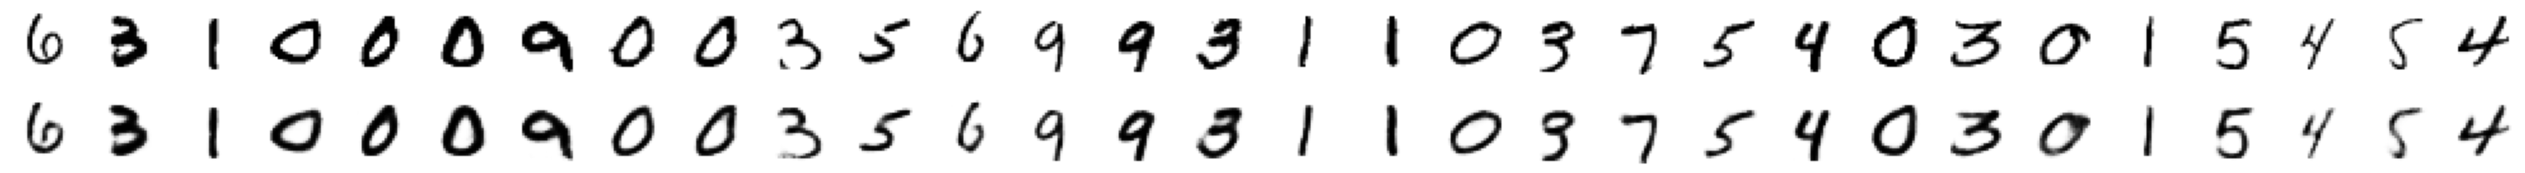

In [ ]:
show_reconstructions(autoencoder, normal_data, 30)
plt.show()

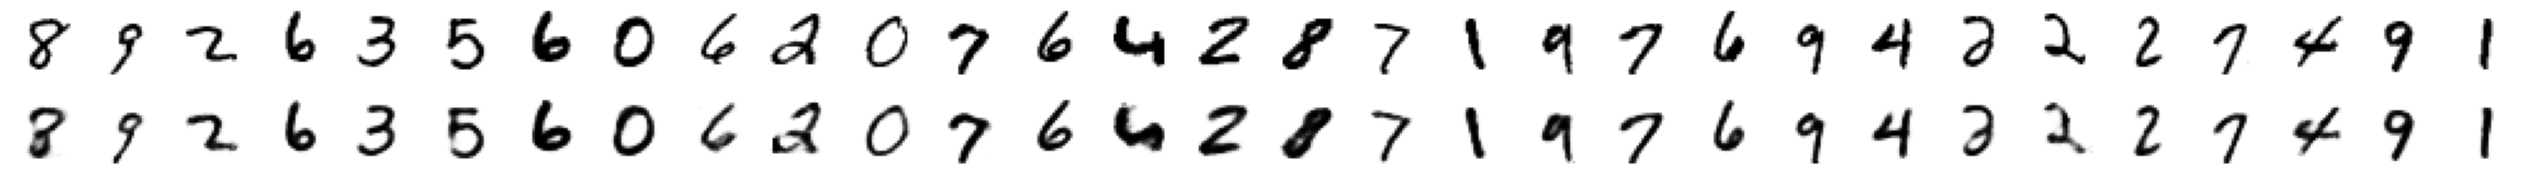

In [ ]:
show_reconstructions(autoencoder, valid_data, 30)
plt.show()

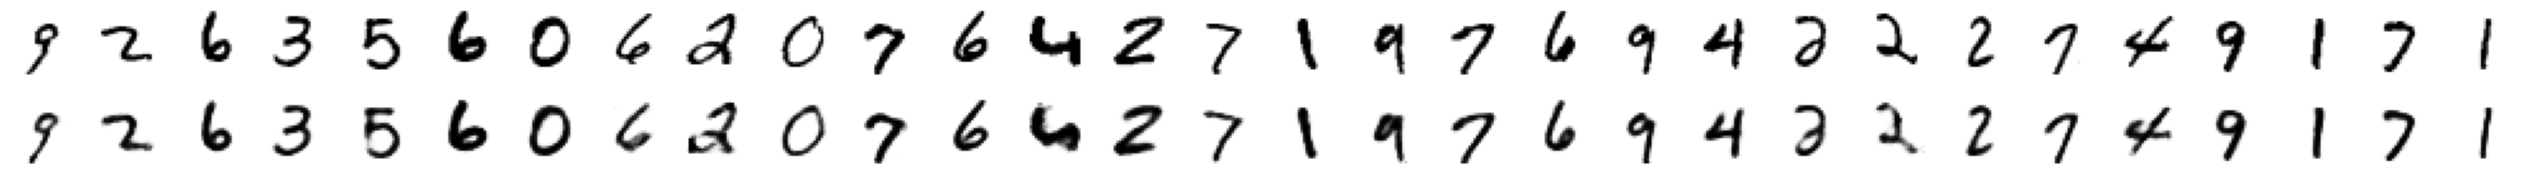

In [ ]:
show_reconstructions(autoencoder, normal_valid_data, 30)
plt.show()

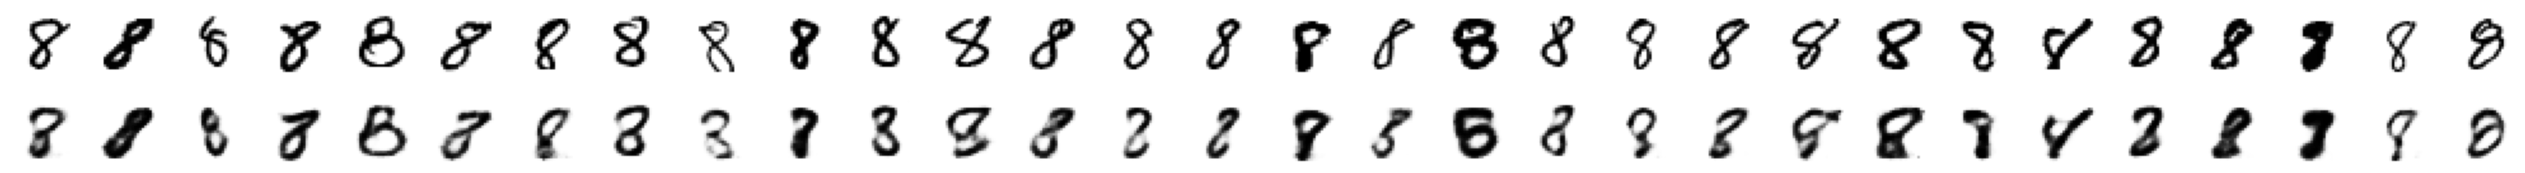

In [ ]:
show_reconstructions(autoencoder, abnormal_valid_data, 30)
plt.show()

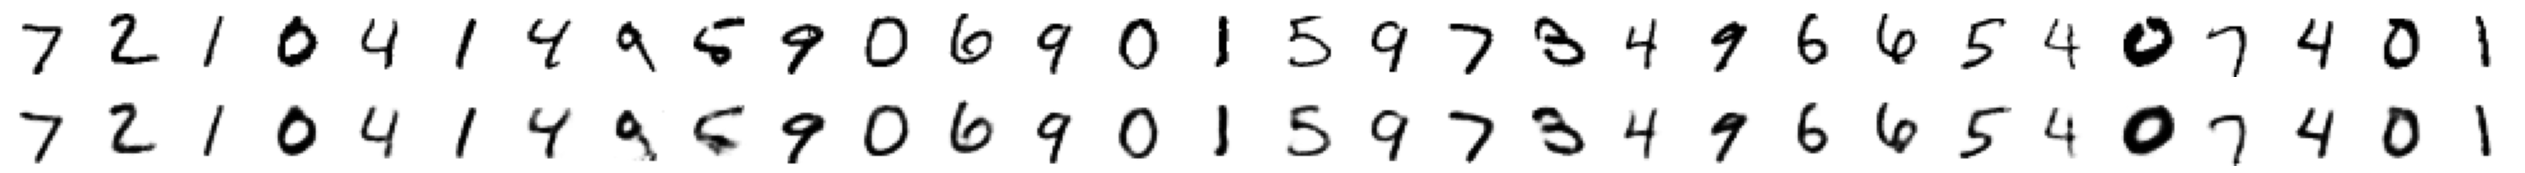

In [ ]:
show_reconstructions(autoencoder, test_data, 30)
plt.show()

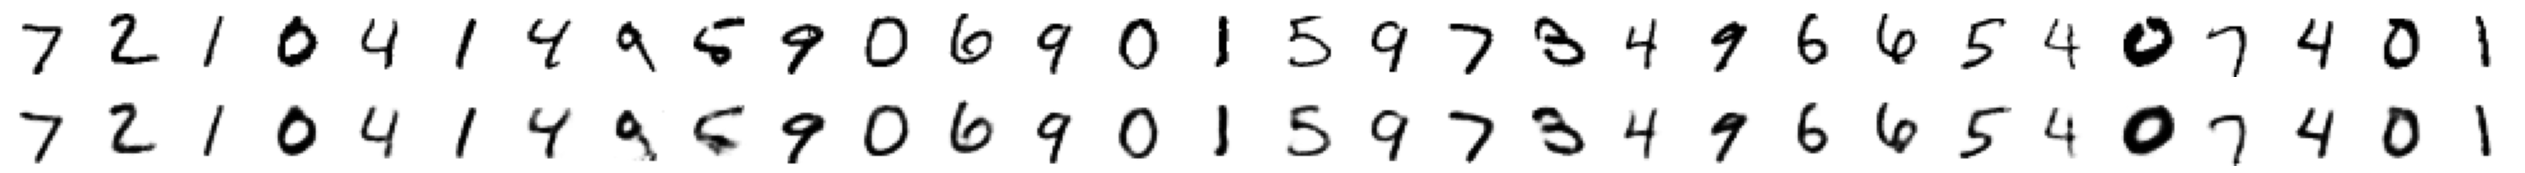

In [ ]:
show_reconstructions(autoencoder, normal_test_data, 30)
plt.show()

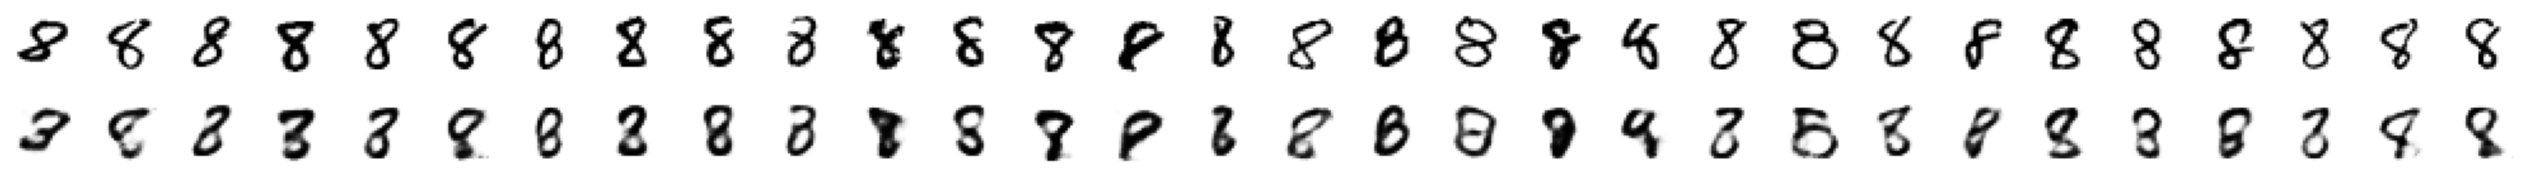

In [ ]:
show_reconstructions(autoencoder, abnormal_test_data, 30)
plt.show()

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

**1-Dim plot of pixels of the first normal test data**

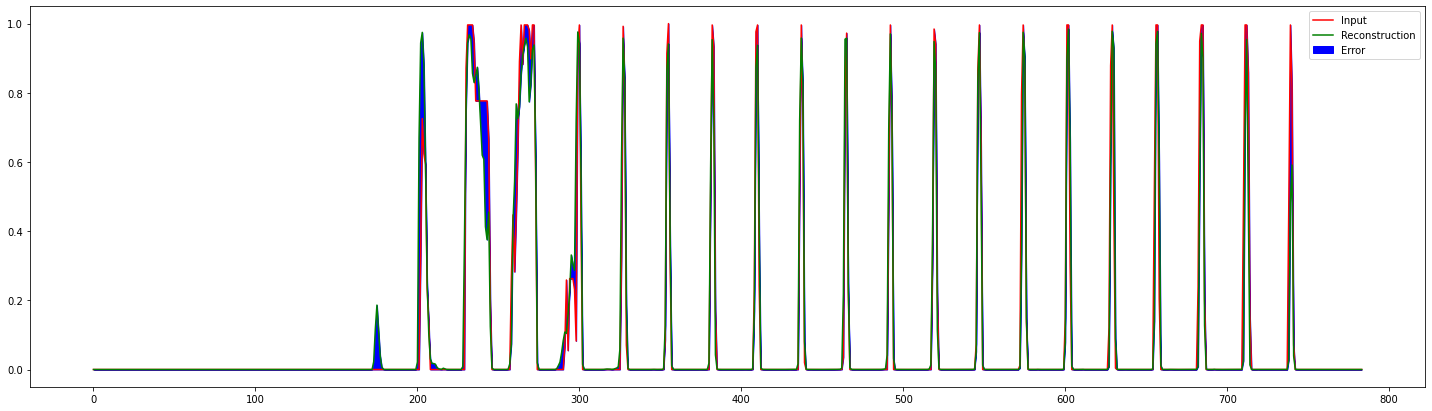

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

**1-Dim plot of pixels of the first abnormal test data**

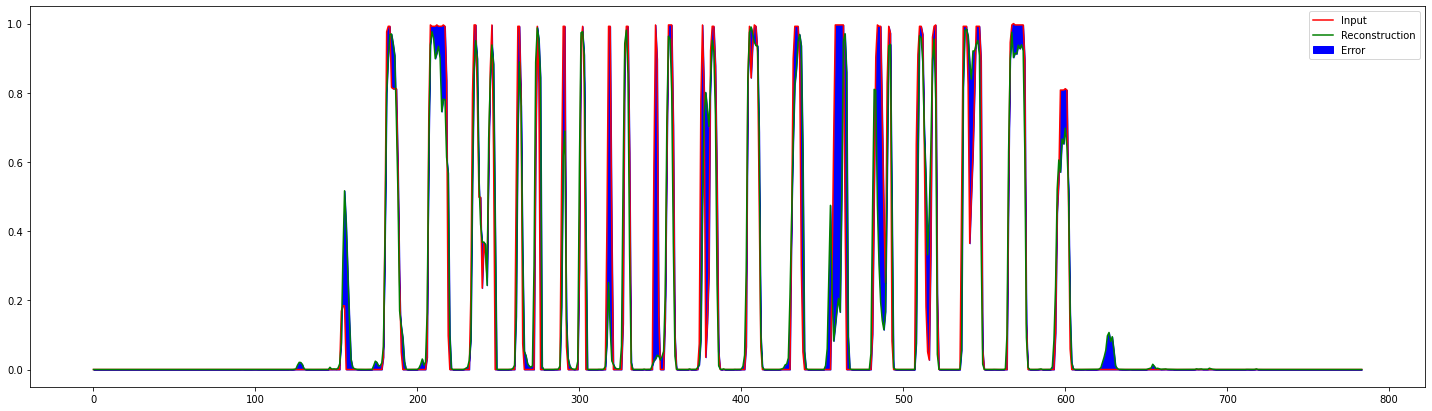

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### **Distributions of the reconstruction losses and the calculation of the threshold.**

**Distribution of the reconstruction losses of the normal training data**



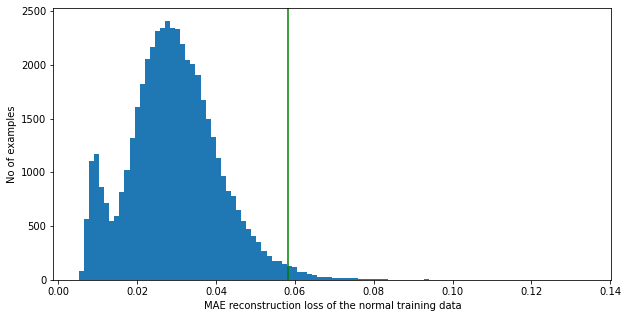

In [ ]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.figure(figsize=(10,5))
plt.hist(train_loss[None,:], bins=100)
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the normal training data")
plt.ylabel("No of examples")
plt.show()

In [ ]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.029296199
Std:  0.011587295


In [ ]:
threshold_train_mean_2_5_std = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std: ", threshold_train_mean_2_5_std)

Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std:  0.05826443573459983


In [ ]:
threshold1 = threshold_train_mean_2_5_std

**Distribution of the reconstruction losses of the abnormal validation data**



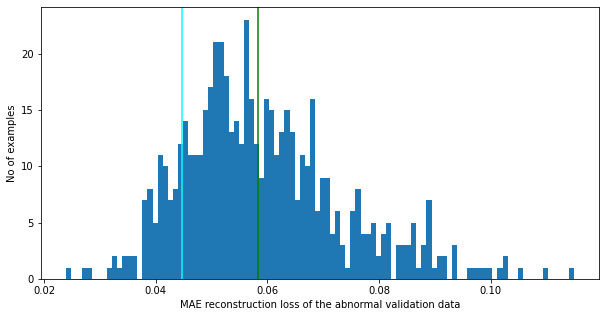

In [ ]:
reconstructions = autoencoder.predict(abnormal_valid_data)
abn_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(abn_valid_loss[None, :], bins=100)
threshold2 = np.mean(abn_valid_loss) - np.std(abn_valid_loss)
plt.axvline(threshold2,c='cyan')
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the abnormal validation data")
plt.ylabel("No of examples")
plt.show()

In [ ]:
abnormal_valid_mean_loss = np.mean(abn_valid_loss)

In [ ]:
abnormal_valid_mean_loss , np.std(abn_valid_loss)

(0.059138227, 0.01439045)

In [ ]:
threshold2 = abnormal_valid_mean_loss - np.std(abn_valid_loss)
print("Threshold2: ", threshold2)

Threshold2:  0.044747777


**Distribution of the reconstruction losses of the normal validation data**

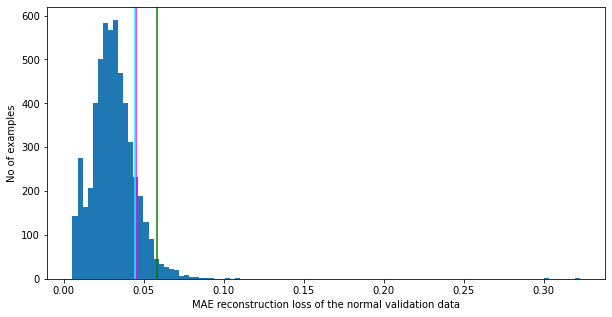

In [ ]:
reconstructions = autoencoder.predict(normal_valid_data)
nl_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(nl_valid_loss[None, :], bins=100)
threshold3 = np.mean(nl_valid_loss) + np.std(nl_valid_loss)
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold1, c='g')
plt.xlabel("MAE reconstruction loss of the normal validation data")
plt.ylabel("No of examples")
plt.show()

In [ ]:
normal_valid_mean_loss = np.mean(nl_valid_loss)

In [ ]:
normal_valid_mean_loss , np.std(nl_valid_loss)

(0.03105453, 0.01397171)

In [ ]:
threshold3 = normal_valid_mean_loss + np.std(nl_valid_loss)
print("Threshold3: ", threshold3)

Threshold3:  0.04502624


**Calculation of a preliminary threshold based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)**

In [ ]:
Avg_of_threshold_2_3 = (threshold2 + threshold3)/2
print("Average of threshold 2 and 3: ", Avg_of_threshold_2_3)

Average of threshold 2 and 3:  0.044887006282806396


In [ ]:
threshold4 = Avg_of_threshold_2_3

### **Calculation of the threshold that gives the best accuracy on the validation data and set this as the threshold.**

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

In [ ]:
increment = (abnormal_valid_mean_loss- normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, increment)
thrs_size = thresholds.shape[0]
accuracies = np.zeros(thrs_size)
for i in range(thrs_size):
  preds = predict(autoencoder, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels_T_F)
argmax = np.argmax(accuracies)
valid_data_best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", valid_data_best_threshold)

The best threshold based on validation data:  0.05576818361878383


In [ ]:
thr_acc = np.zeros((thrs_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax - 2 : argmax + 3]

array([[0.05520651, 0.92266667],
       [0.05548735, 0.92333333],
       [0.05576818, 0.92566667],
       [0.05604902, 0.92533333],
       [0.05632986, 0.92566667]])

In [ ]:
threshold5 = valid_data_best_threshold

In [ ]:
threshold = threshold5

#### **Distribution of the reconstruction losses of all the validation data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

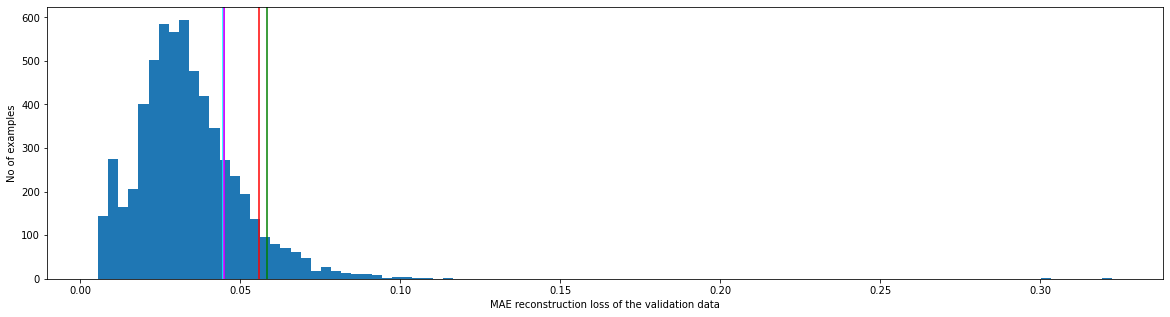

In [ ]:
reconstructions = autoencoder.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), valid_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

#### **Distribution of the reconstruction losses of the test data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

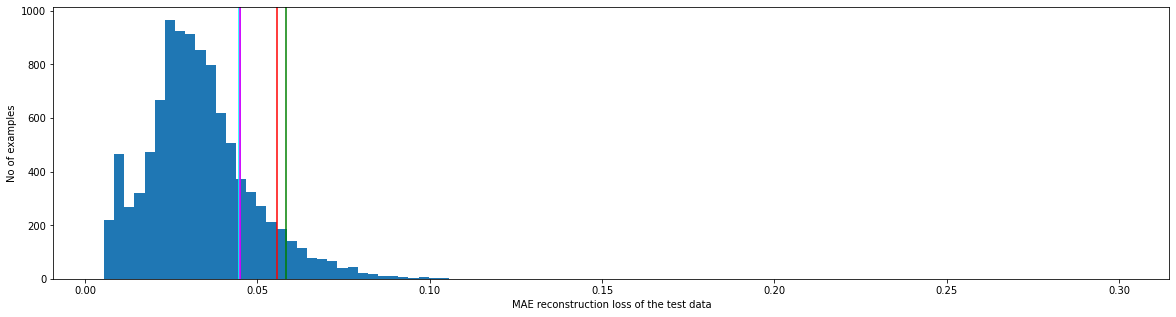

In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(test_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

#### **Mean and standard deviation of reconstruction losses for normal and abnormal test data**

In [ ]:
reconstructions = autoencoder.predict(normal_test_data)
nl_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_test_data.reshape(-1,784))
np.mean(nl_test_loss) , np.std(nl_test_loss)

(0.03051131, 0.013135988)

In [ ]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.058316402, 0.014159251)

### **Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data**

In [ ]:
# def predict(model, data, threshold):
#  reconstructions = model.predict(data)
#  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
#  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, valid_data_best_threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             821   9179
 label: F   [[506   468]    974
        T    [315   8711]]   9026
Accuracy = 0.9217
Precision = 0.9490140538184988
Recall = 0.9651008198537558


In [ ]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 506  468]
 [ 315 8711]]


#### **Extra accuracy info**
**Just informative. Please record the above accuracy.**

#### Accuracy on the test data with threshold set based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)

In [ ]:
preds = predict(autoencoder, test_data, Avg_of_threshold_2_3)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1869   8131
 label: F   [[820   154]    974
        T    [1049   7977]]   9026
Accuracy = 0.8797
Precision = 0.9810601402041569
Recall = 0.8837801905606028


#### Accuracy on the test data with threshold set based on the mean of the training data MAE reconstruction losses + 2.5 std

In [ ]:
preds = predict(autoencoder, test_data, threshold_train_mean_2_5_std)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             657   9343
 label: F   [[431   543]    974
        T    [226   8800]]   9026
Accuracy = 0.9231
Precision = 0.941881622605159
Recall = 0.9749612231331708
